# Calculating Monthly Overdose deaths from CDC data
Author: Samir Akre
Last Updated: Jan 3 2021

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import src.load_data as ld
import src.defilter_data as dd
import src.estimate_error as ee
import importlib
import scipy.stats as stats

## Import and clean data
- 'predicted_val' column is 12-month rolling sum of monthly overdose deaths
- 'Deaths' column are the imputed monthly overdose deaths

In [2]:
importlib.reload(dd)
importlib.reload(ld)
data = ld.load_data().dropna(how='all')
data

,timestamp,location,predicted_val,Deaths
64,2015-01-01,Alabama,742,65.0
63,2015-02-01,Alabama,749,60.0
62,2015-03-01,Alabama,758,79.0
61,2015-04-01,Alabama,764,69.0
60,2015-05-01,Alabama,782,74.0
...,...,...,...,...
3519,2020-08-01,Wyoming,89,NaN
3520,2020-09-01,Wyoming,97,NaN
3571,2020-10-01,Wyoming,100,NaN
3622,2020-11-01,Wyoming,110,NaN


## Impute/Predict 2020 monthly data
- 11 months of monthly death data used to "unroll" to 12 month rolling sum reported for 2020 months

In [70]:
k = 12 # 12 month rolling sum
time_filt = data[data.timestamp >= pd.to_datetime('2018-11-01')]
time_filt['raw_predicted_val'] = np.nan
for loc in time_filt['location'].unique():
    truth = time_filt.loc[time_filt.location == loc, 'Deaths'].values
    if time_filt.loc[data.location == loc, 'predicted_val'].iloc[11:].empty:
        continue
    pred = dd.defilter(time_filt.loc[data.location == loc, 'predicted_val'].iloc[11:].values, k, truth[:11])
    time_filt.loc[time_filt.location == loc, 'raw_predicted_val'] = pred
time_filt['raw_predicted_val'] = time_filt['raw_predicted_val'].astype(float)

<ipython-input-70-2b184b6ec647>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filt['raw_predicted_val'] = np.nan
/Users/akre96/Code/cdc_overdose/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
<ipython-input-70-2b184b6ec647>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [71]:
truth, pred

(array([ 7.5,  3. ,  7. ,  4. , 10. ,  3. ,  4. ,  7. ,  7. ,  7. ,  7.5,
         8.5,  4. , 11. ,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan]),
 array([ 7.5,  3. ,  7. ,  4. , 10. ,  3. ,  4. ,  7. ,  7. ,  7. ,  7.5,
         1. ,  4.5, 10. , 13. ,  6. , 11. ,  5. ,  9. ,  3. , 11. ,  8. ,
        15.5,  4. , 14.5,  1. ]))

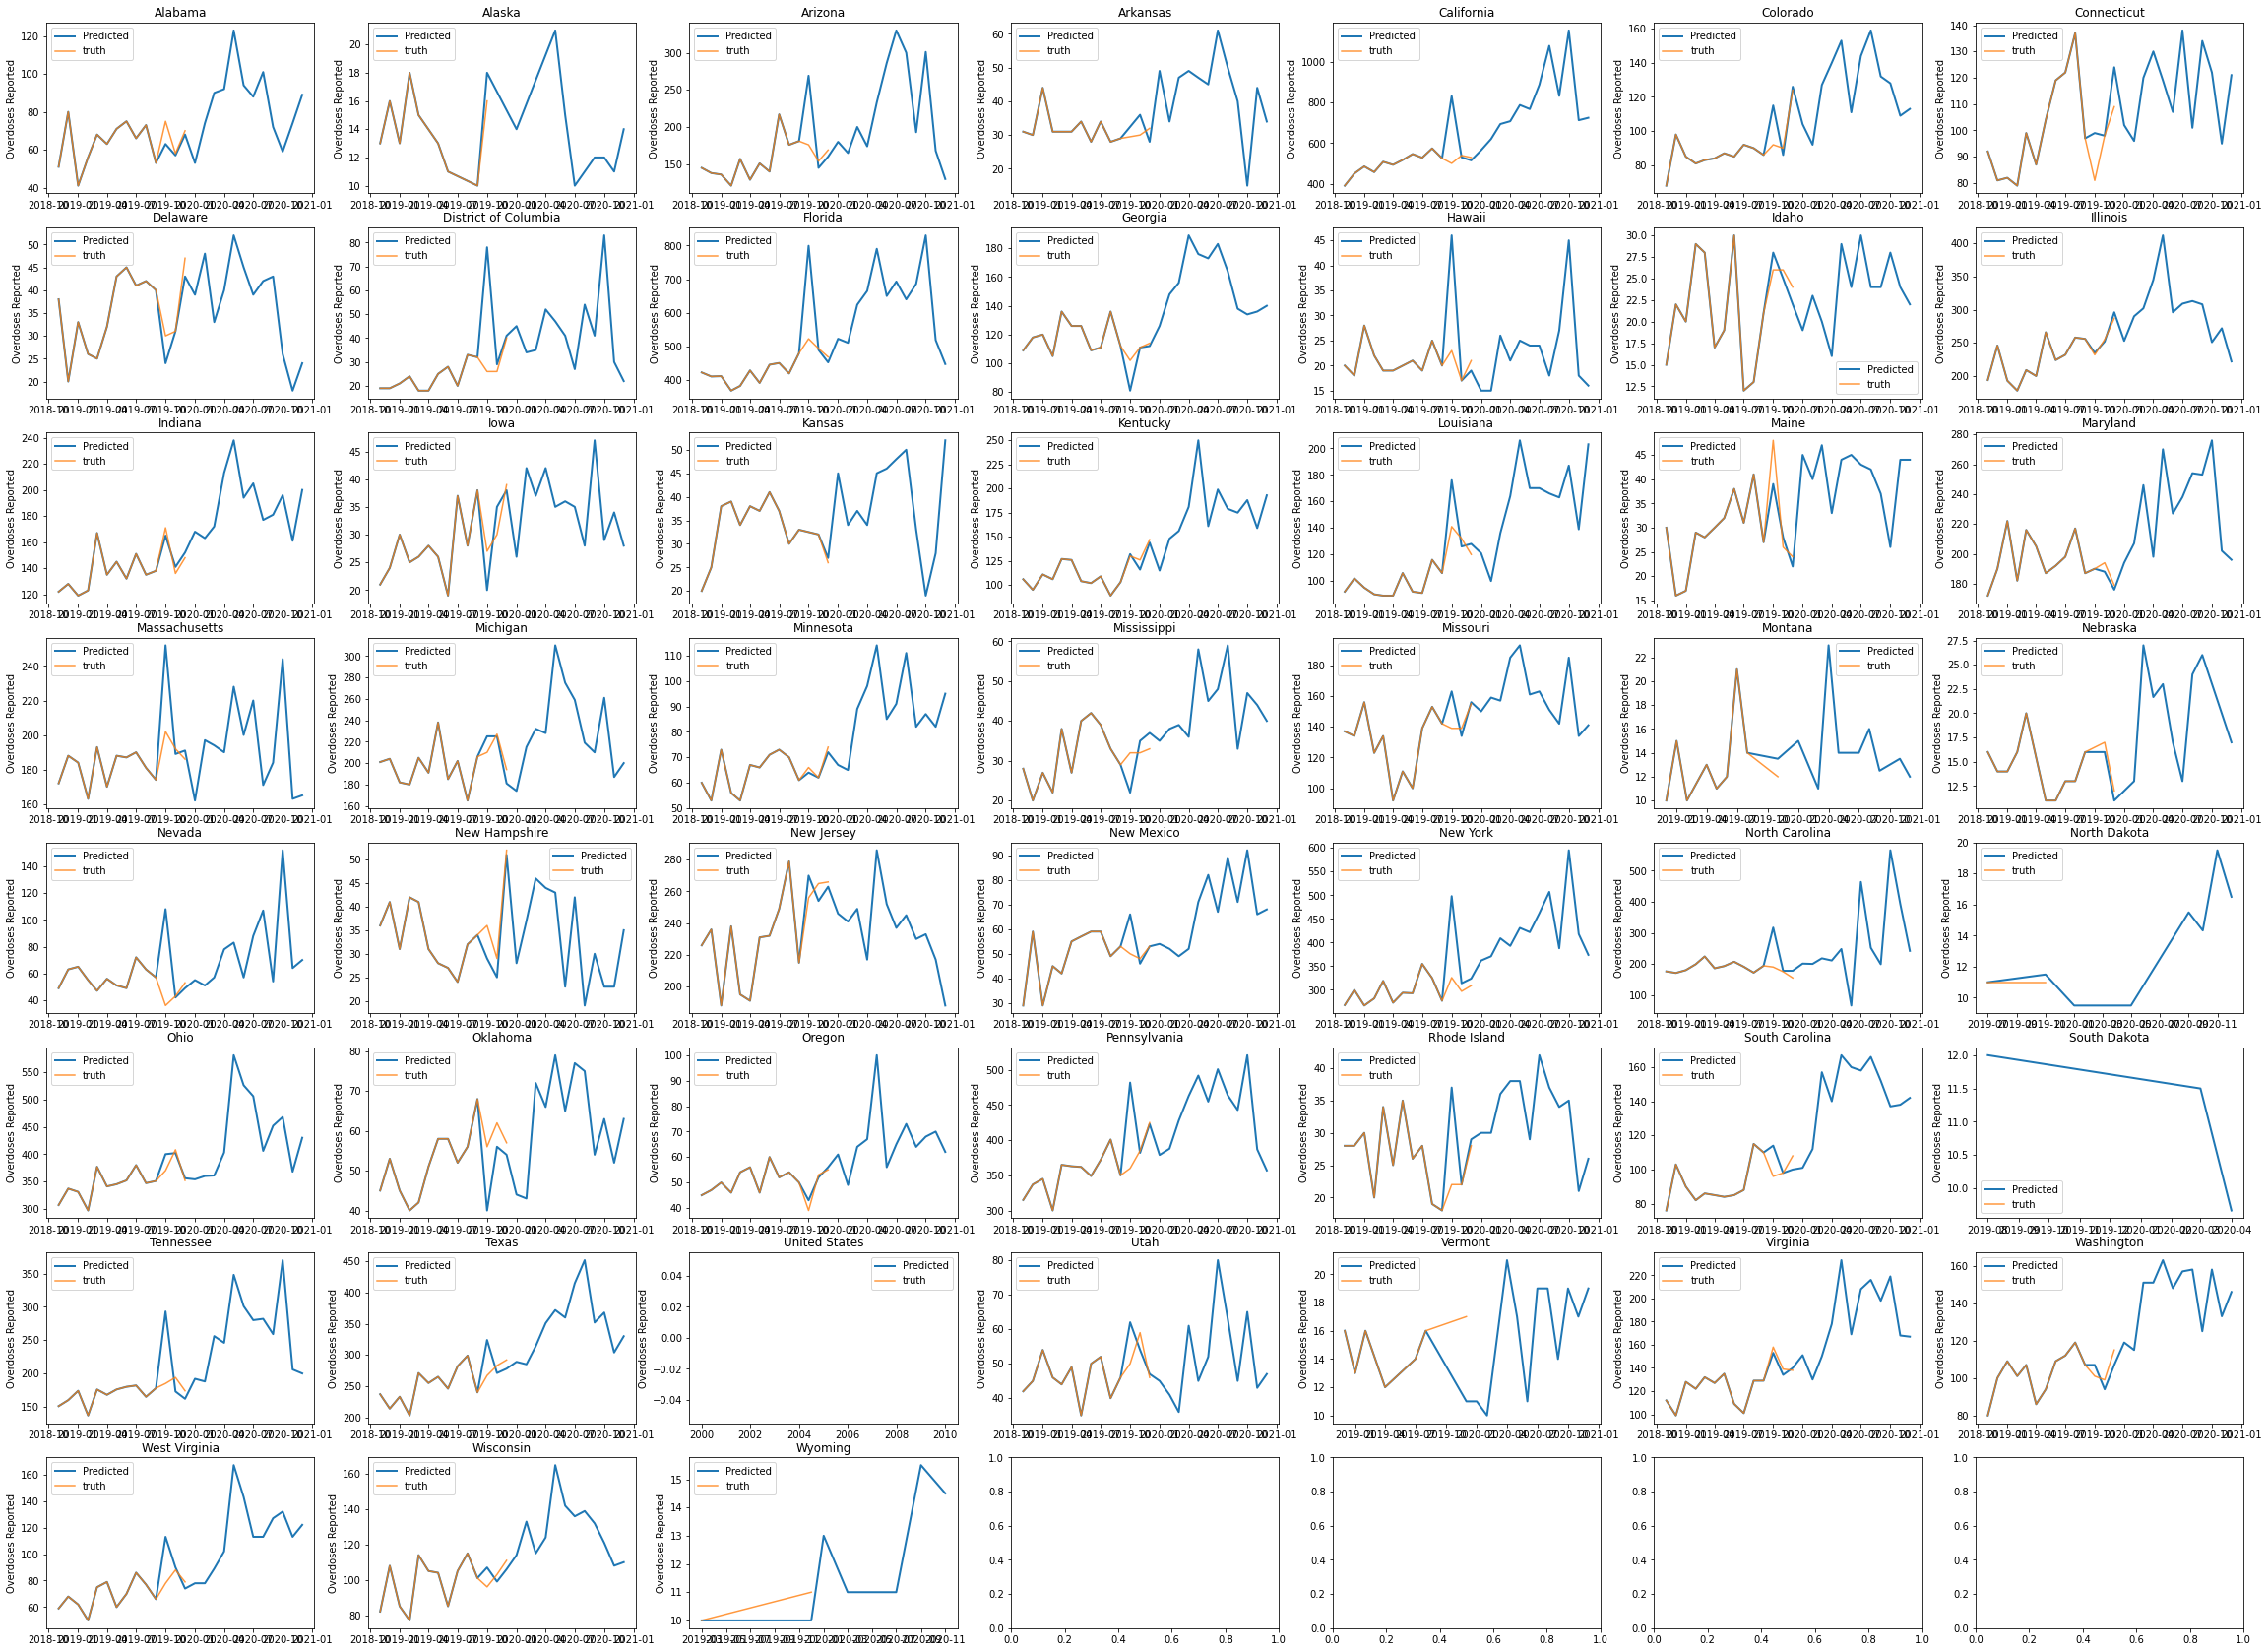

In [72]:
fig, axes = plt.subplots(nrows=8, ncols=7, figsize=(40,30))
i = 0
for loc, loc_data in time_filt.groupby('location'):
    ax=axes.flatten()[i]
    filt_data = loc_data.copy()
    # Hides values less than 10 from plot
    for col in ['raw_predicted_val', 'Deaths']:
        filt_data.loc[filt_data[col] <= 9] = np.nan
    sns.lineplot(
        x='timestamp',
        y='raw_predicted_val',
        data=filt_data,
        label='Predicted',
        markers=True,
        lw=2,
        ax=ax
    )
    sns.lineplot(
        x='timestamp',
        y='Deaths',
        data=filt_data,
        label='truth',
        markers=True,
        alpha=.8,
        ax=ax
    )
    ax.set_ylabel('Overdoses Reported')
    ax.set_title(loc)
    ax.set_xlabel('')
    i+=1

In [73]:
time_filt[[
    'location', 'Deaths', 'timestamp', 'raw_predicted_val'
]].to_csv('output/monthly_overdose_computed_m4.csv', index=False)

In [74]:
time_filt[time_filt.Deaths.isna()].groupby('timestamp').raw_predicted_val.sum()

timestamp
2020-01-01    6356.0
2020-02-01    6522.0
2020-03-01    7356.0
2020-04-01    7703.0
2020-05-01    9192.0
2020-06-01    7888.0
2020-07-01    8850.0
2020-08-01    8606.0
2020-09-01    7718.0
2020-10-01    9382.0
2020-11-01    6976.0
2020-12-01    6930.0
Name: raw_predicted_val, dtype: float64

# Error Analysis

## Testing rolling sum unrolling method

In [34]:
dd.unroll_sum(cumTruth[11:], 12, truth[:11] - .5)

[0.5        0.66589613 0.8271947  0.97942554 1.1183698  1.24017685
 1.34147098 1.41944498 1.4719379  1.49749499 1.49540796 7.46573465
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
[0.5        0.66589613 0.8271947  0.97942554 1.1183698  1.24017685
 1.34147098 1.41944498 1.4719379  1.49749499 1.49540796 7.46573465
 1.40929743 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0. 

array([ 5.00000000e-01,  6.65896133e-01,  8.27194697e-01,  9.79425539e-01,
        1.11836980e+00,  1.24017685e+00,  1.34147098e+00,  1.41944498e+00,
        1.47193790e+00,  1.49749499e+00,  1.49540796e+00,  7.46573465e+00,
        1.40929743e+00,  1.32766035e+00,  1.22308588e+00,  1.09847214e+00,
        9.57272627e-01,  8.03400467e-01,  6.41120008e-01,  4.74928614e-01,
        3.09432037e-01,  1.49216772e-01, -1.27704859e-03,  5.86212129e+00,
       -2.56802495e-01, -3.54752607e-01, -4.29014501e-01, -4.77530118e-01,
       -4.98954917e-01, -4.92695143e-01, -4.58924275e-01, -3.98578223e-01,
       -3.13329392e-01, -2.05540326e-01, -7.81982417e-02,  6.06516776e+00,
        2.20584502e-01,  3.83744835e-01,  5.50127010e-01,  7.15119988e-01,
        8.74151231e-01,  1.02281342e+00,  1.15698660e+00,  1.27295236e+00,
        1.36749687e+00,  1.43799998e+00,  1.48250779e+00,  7.49978683e+00,
        1.48935825e+00,  1.45151105e+00,  1.38729411e+00,  1.29848711e+00,
        1.18755122e+00,  

In [20]:
time = np.arange(0, 12*6)/12
truth = np.random.randint(0, 1000, size=time.shape)
truth = np.sin(time*2) + 1
cumTruth = pd.Series(truth).rolling(window=12).sum().values
truth[:11]

array([1.        , 1.16589613, 1.3271947 , 1.47942554, 1.6183698 ,
       1.74017685, 1.84147098, 1.91944498, 1.9719379 , 1.99749499,
       1.99540796])

In [46]:
importlib.reload(dd)
dd.month_change_estimate(cumTruth[10:], 12, truth[:11])
cumTruth[12] - cumTruth[11], truth[11] - truth[10] + (truth[1] - truth[0])

(0.909297426825681, 0.1362228286991498)

poorlyinformed


<AxesSubplot:>

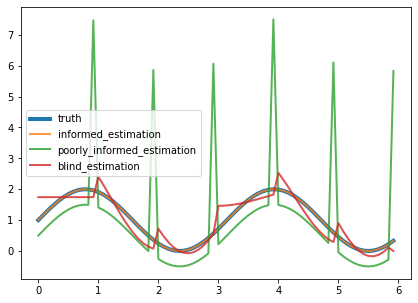

In [48]:
importlib.reload(dd)
fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(
    x=time,
    y=truth,
    label='truth',
    lw=4,
    ax=ax
)
sns.lineplot(
    x=time,
    y=dd.unroll_sum(cumTruth[11:], 12, truth[:11]),
    label='informed_estimation',
    lw=2,
    alpha=.8,
    ax=ax
)
print('poorlyinformed')
sns.lineplot(
    x=time,
    y=dd.unroll_sum(cumTruth[11:], 12, truth[:11] - .5),
    label='poorly_informed_estimation',
    lw=2,
    alpha=.8,
    ax=ax
)

sns.lineplot(
    x=time,
    y=dd.unroll_sum(cumTruth[12:], 12),
    label='blind_estimation',
    lw=2,
    alpha=.8,
    ax=ax
)


## Discrepency in computed rolling sum of CDC monthly data vs reported rolling sum from CDC

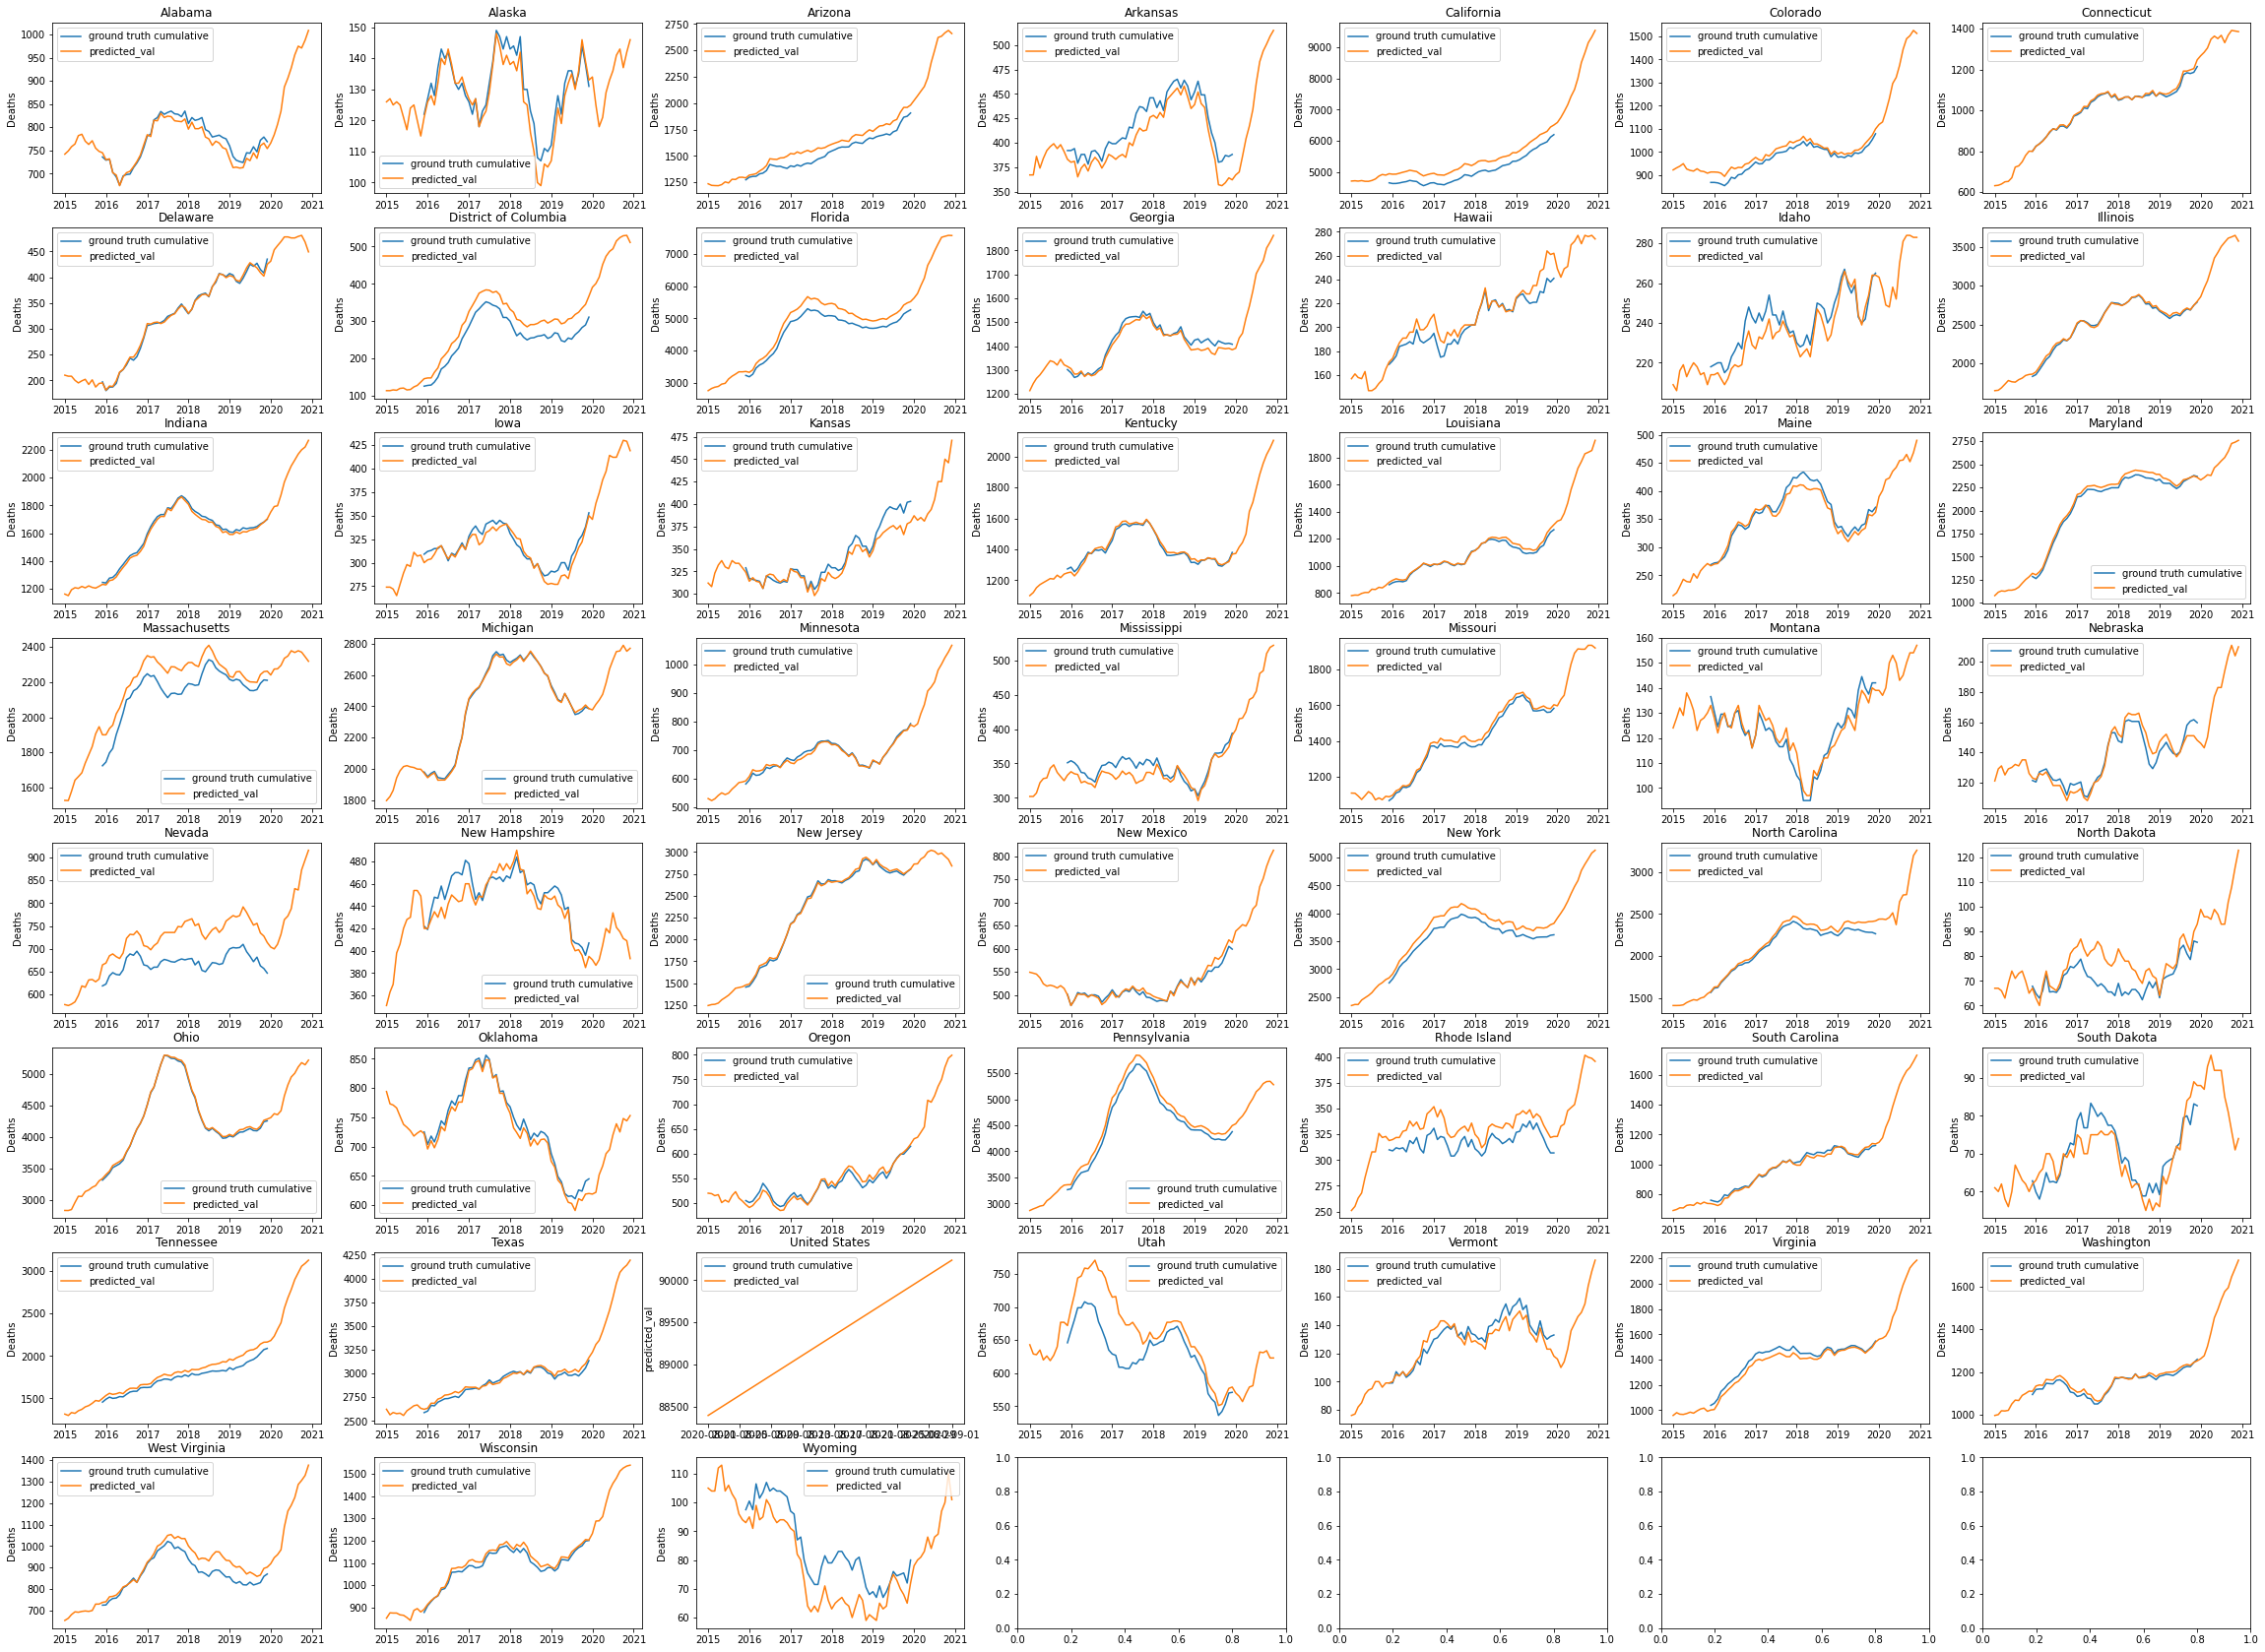

In [31]:
fig, axes = plt.subplots(nrows=8, ncols=7, figsize=(40,30))
i = 0
for loc, loc_data in data.groupby('location'):
    ax=axes.flatten()[i]
    int_loc = loc_data.loc[loc_data.Deaths != 'Suppressed']
    int_loc.Deaths = int_loc.Deaths.rolling(12).sum()
    sns.lineplot(
        y='Deaths',
        x='timestamp',
        data=int_loc,
        label='ground truth cumulative',
        ax=ax,
    )
    sns.lineplot(
        y='predicted_val',
        label='predicted_val',
        x='timestamp',
        data=int_loc,
        ax=ax
    )
    ax.vlines(loc_data.loc[loc_data.Deaths == 'Suppressed', 'timestamp'], *ax.get_ylim(), lw=1, alpha=.5, color='red')
    ax.set_title(loc)
    ax.set_xlabel('')

    i+=1


## Calculate prediction error at n-months out from 11 months of ground truth data used

In [32]:
data.dropna().shape, data.shape

((3060, 4), (3674, 4))

In [75]:
importlib.reload(ee)
error_data = ee.calculate_error(data.dropna(), max_months_out = 15)
error_data.to_csv('output/full_error.csv', index=False)
error_data

,location,pred_timestamp,truth,error,pred,percent_error,month_out
0,Alabama,2015-12-01,51.0,-9.0,60.0,17.647059,1
765,Alabama,2016-01-01,58.0,-1.0,59.0,1.724138,1
1,Alabama,2016-01-01,58.0,8.0,50.0,13.793103,2
1530,Alabama,2016-02-01,62.0,-1.0,63.0,1.612903,1
766,Alabama,2016-02-01,62.0,0.0,62.0,0.000000,2
...,...,...,...,...,...,...,...
26008,Wyoming,2019-10-01,8.5,-0.5,9.0,5.882353,14
25244,Wyoming,2019-10-01,8.5,-0.5,9.0,5.882353,15
26773,Wyoming,2019-11-01,4.0,1.0,3.0,25.000000,14
26009,Wyoming,2019-11-01,4.0,1.0,3.0,25.000000,15


In [76]:
error_data[~error_data.error.isna()].pred_timestamp.nunique()

49

In [77]:
error_data.groupby('month_out').error.describe()

,count,mean,std,min,25%,50%,75%,max
month_out,,,,,,,,
1,1785.0,-26.784874,68.241835,-385.0,-28.0,-4.500000,5.000000,59.0
2,1785.0,-0.180392,5.571844,-34.0,-3.0,0.000000,2.000000,34.0
3,1785.0,-0.173669,5.549377,-34.0,-3.0,0.000000,2.666667,34.0
4,1785.0,-0.046499,5.692742,-34.0,-3.0,0.000000,3.000000,34.0
5,1785.0,-0.112605,5.718370,-34.0,-3.0,0.000000,3.000000,34.0
6,1785.0,-0.198319,5.814384,-34.0,-3.0,0.000000,3.000000,34.0
7,1785.0,-0.178151,5.831313,-34.0,-3.0,0.000000,3.000000,34.0
8,1785.0,-0.197199,5.826909,-34.0,-3.0,0.000000,3.000000,34.0
9,1785.0,-0.145098,5.810122,-34.0,-3.0,0.000000,3.000000,34.0


<AxesSubplot:xlabel='percent_error', ylabel='location'>

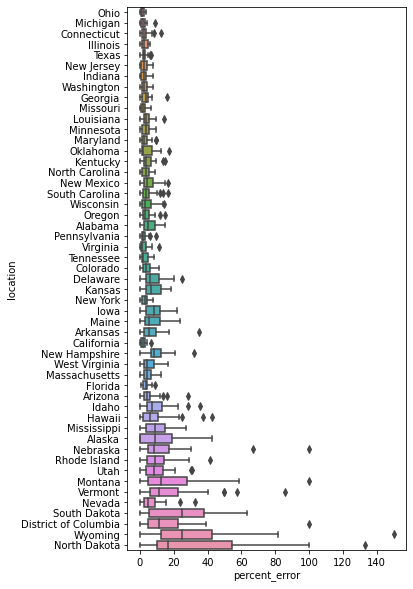

In [78]:
fig, ax = plt.subplots(figsize=(5,10))
m_last_error = error_data[error_data.month_out == 8]
order = error_data.groupby('location').percent_error.mean().sort_values().index
sns.boxplot(
    x='percent_error',
    y='location',
    data=m_last_error,
    order=order,
    ax=ax
)

## Summarize prediction error

In [37]:
stds = error_data.groupby(['location', 'month_out']).error.std()
abs_mean = error_data.groupby(['location', 'month_out']).error.apply(lambda x: np.mean(np.abs(x)))
mape = error_data.groupby(['location', 'month_out']).percent_error.apply(lambda x: np.mean(np.abs(x)))
std_pe = error_data.groupby(['location', 'month_out']).percent_error.std()
error_summary = pd.DataFrame(stds).rename(columns={'error': 'Std Error'}).reset_index().merge(
    pd.DataFrame(abs_mean).rename(columns={'error': 'Mean Absolute Error'}).reset_index()

).merge(
    pd.DataFrame(mape).rename(columns={'percent_error': 'Mean Absolute Percent Error'}).reset_index()
).merge(
    pd.DataFrame(std_pe).rename(columns={'percent_error': 'Std Percent Error'}).reset_index()
)
error_summary.to_csv('output/prediction_error_summary.csv', index=False)
error_summary

,location,month_out,Std Error,Mean Absolute Error,Mean Absolute Percent Error,Std Percent Error
0,Alabama,1,9.314008,9.486486,15.017504,11.405761
1,Alabama,2,4.176655,3.486486,5.623928,4.209549
2,Alabama,3,4.082851,3.378378,5.444192,3.987158
3,Alabama,4,4.381404,3.621622,5.801903,4.077836
4,Alabama,5,4.379347,3.594595,5.738814,4.125513
...,...,...,...,...,...,...
658,Wyoming,9,2.311919,1.770270,31.382504,30.784301
659,Wyoming,10,2.231867,1.729730,30.713263,30.152198
660,Wyoming,11,2.266415,1.770270,31.057725,30.059930
661,Wyoming,12,2.262353,1.756757,31.009463,30.089026
